# Capstone Project - Web scraping

## 1. Imports

In [1]:
# standard computing libraries
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

# webscraping
from bs4 import BeautifulSoup
import requests

# geocoder for retrieving coordinates of postcodes
import geocoder

# k-means clustering
from sklearn import preprocessing
from sklearn.cluster import KMeans


# folium for maps
import folium

# geopandas for advanced geojson handling
import geopandas

# library to access overpass api in a more convenient way
import overpass

# basic os library for execution of external programms
import os

# time library for sheduling
import time



# ipython command to use matplotlib
%matplotlib inline

## 2. Scraping postal codes for Toronto from Wikipedia

In [2]:
postcode = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

In [3]:
postcodesoup = BeautifulSoup(postcode.content) 

In [4]:
list_postcodes = list()

for tr in postcodesoup.find_all("tr")[2:-5]:
    
    row = (td.text for td in tr.find_all("td"))
    
    list_postcodes.append(row)

## 3. Creating and preparing a pandas DataFrame

In [5]:
df_raw = pd.DataFrame(list_postcodes, columns=["Postcode","Borough","Neighbourhood"])

### 3.1. Preparing helper functions

In [6]:
def concatNeighbourhood(row):
    
    return pd.Series(dict(Borough = row['Borough'].unique()[0],
                        Neighbourhood = ', '.join(row['Neighbourhood'])))

### 3.2 Cleaning and preparing DataFrame
I used modern possibilities of method chaining to keep my code clean. 

In [7]:
df_post = (df_raw
            .query('Borough != "Not assigned"')
            .assign(Neighbourhood = lambda x: x["Neighbourhood"].str[:-1].replace('Not assigned', x["Borough"]))
            .groupby('Postcode').apply(concatNeighbourhood)
            .reset_index()
)

df_post.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
df_post.shape

(103, 3)

## 4. Getting coordinates of postcodes

### 4.1 Testing geocoder package 

In [9]:
#postal_code = 'M5G'

# initialize your variable to None
#lat_lng_coords = None

# loop until you get the coordinates
#while(lat_lng_coords is None):
#  g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#  lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

Runs infinitely, meaning that i can't get a single pair of coordinates for a postcode therefore we need to use the CSV file supplied in the course.

### 4.2 Read coordinates CSV to dataframe

In [10]:
df_coord = pd.read_csv('Geospatial_Coordinates.csv')

df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 4.3 Add coordinates to dataframe containing neighbourhoods

I used pd.merge() to join the dataframes, then I dropped the column containing the duplicate postal code and renamed the existing Postcode column to match the example column in the course

In [11]:
df_post_coord = (pd.merge(df_post, df_coord, left_on="Postcode", right_on="Postal Code")
                   .drop("Postal Code", axis=1)
                   .rename(columns={"Postcode":"PostalCode"}))

df_post_coord.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## 5. Cluster the neighbourhoods

### 5.1 Pick neighbourhoods with borough containing 'Toronto'

In [12]:
df_toronto = df_post_coord[df_post_coord['Borough'].str.contains('Toronto')]

df_toronto.shape

(38, 5)

## 5.2 Use folium to print the neighbourhoods, using their coordinates
I printed the neighbourhoods as circles with a radius showing the radius we would later use for finding venues

In [13]:
nh_map = folium.Map(location=(43.6815,-79.5284), zoom_start=11)

for i, nh in df_toronto.iterrows():
    folium.Circle(
        radius=500,
        location=[nh['Latitude'], nh['Longitude']],
        popup=nh['Neighbourhood'],
        color='crimson',
        fill=False,
    ).add_to(nh_map)
    
nh_map

I don't realy like the output I get here. It looks like our aproach leads to a very bad coverage of Torrontos total area. And it also seems like we have a lot of heavily overlapping arreas in the city center. This would lead to a very blury result. To prove my assumption of bad area coverage I included an image showing the boundaries of torronto city.

<img src="files/Toronto_boundaries.png">

## 5.3 Try another source of information for geospacial neighbourhood data

I switched to downloading location data from Open Street Maps. This has two huge advantage. 
First, it highly increases the accuracy of location data. Open Street Maps supplies us with high resolution bounds for all administrative neighbourhoods in toronto. This takes away the blur in our analysis and lets us gather alls venues of a certain neighbourhood

To get data from OSM we can use the overpass api which has a wrapper package for python. We first initialize the API and then we download data about neighbourhood borders.

In [14]:
overpass_api = overpass.API(timeout=600)

In [15]:
query = """
area["name"="Toronto"]["admin_level" ="6"];
relation["boundary"="administrative"]["admin_level"="9"](area);
(._;>;);
out;
"""

response = overpass_api.get(query, responseformat="json")

Since I found no possibility convert the raw json output of overpass to geojson format, here comes a little trick. We need to use a external programm to achieve this. The programm we use is called 'osmtogeojson' and is written to run on the node.js environment. 

If you want to try the steps below, you need install node.js and then install 'osmtogeojson' by running 'npm install -g osmtogeojson' in your console (npm is the node.js equivalent of pip).

We save the downloaded raw json to the file system und then run osmtogeojson and convert it to a geojson file.

In [16]:
with open("toronto_bounds_raw.json", "w") as file:
    file.write(json.dumps(response))
    
os.system('osmtogeojson toronto_bounds_raw.json > toronto_bounds.geojson')

0

We can now import the generated geojson file using the library geopandas, a pandas derivative that is mainly made for processing geo data like we saved in our geojson. 

Since the geojson file we downloaded still contains data we don't need and which spoils our our visualizations later on, we filter the imported file and save it to the file system again so we can use it with folium later. 

In [17]:
gdf_toronto_bounds_raw = geopandas.read_file('toronto_bounds.geojson')
gdf_toronto_bounds = gdf_toronto_bounds_raw[gdf_toronto_bounds_raw["id"].str.startswith("relation")]
gdf_toronto_bounds.to_file("toronto_bounds.geojson", driver='GeoJSON')

Now we can display our neighbourhood boundaries using folium choropleth maps

In [18]:
nh_map = folium.Map(location=(43.6815,-79.5284), zoom_start=11) 

folium.Choropleth(
    geo_data="toronto_bounds.geojson"
).add_to(nh_map)

                  
nh_map

Looks like our data about the location of the neighbourhoods just got a lot more accurate.

## 5.4 Download data about places

Now we want to get the data on which places are present in each of the neighbourhoods. Unfortunately Foursquare does not allow us to use polygons to retrieve venues in a certain area. Therefore we try to download all venues in the area of Toronto to be able to split it into the correct neighbourhoods later using latitude and longitude.

In [19]:
CLIENT_ID = 'TLLSXQMPOKLY0NLU0ZRA4MUW45XBYO5G0P5B5VFW0ZRJMY2U' 
CLIENT_SECRET = 'QH2K33NY2RZQPSHRBYGLNMFDYYEPLUTOA44IND2NCDEQVXDD'
VERSION = '20190706'

In [20]:
url = "https://api.foursquare.com/v2/venues/search/"

params = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": VERSION,
    "ll": "43.7000, -79.35000",
    "radius": 25000,
    "limit": 1000000
}

In [21]:
results = requests.get(url, params).json()

In [22]:
len(results['response']['venues'])

103

This does not look like a reasonable amount of venues for the whole area we printed as a red circle on the map above. 

When we look into the foursquare Place API docs, we can find out that this beheavour is due to restrictions on the limit parameter as well as on the radius parameter.

In my opinion the foursquare Places API is not very useful for this kind of datascience task since it only allows us to retrieve data with a very poor accuracy. It also delivers a very small amount of data points leading to the fact that in city centers we barely get all the venues located at the very center of the circle we defined as radius. 

At this point I'm moving away from Foursquare since its limitation are simply to strict and it does not feature any data relevant for this project that I could not get from OSM.

First, we define a function that allows us to retrieve all places tagged with the key 'amenity' for an area.

In [23]:
def retrieveAmenities(relation_id):
    
    area_id = relation_id + 3600000000 

    query = """
    area({});
    (
      node["amenity"](area);
      way["amenity"](area);
      relation["amenity"](area);
    );
    (._;>;);
    out;
    """.format(area_id)
    
    overpass_api.endpoint

    response = overpass_api.get(query, responseformat="json")
    
    return response

The following function takes a list of amenities, groups them by amenity type and adds information about the area we found these amenities in.

In [24]:
def group_nh_amenities(amenities, nh_id, nh_name, nh_area):
    df_amenities = json_normalize(amenities['elements'])
    
   
    
    return (df_amenities
             .groupby('tags.amenity')['id']
                .count()
                .to_frame()
             .transpose()
             .reset_index()
             .assign(index=lambda x: x.index.astype(int))
             
             .assign(nh_area=nh_area)
             .assign(nh_id=nh_id)
             .assign(nh_name=nh_name)
           )

Now we can run the functions defined before iteratively for each neighbourhood and add them to a list which can be concatinated to a dataframe

In [25]:
nh_list = list()



for i, row in gdf_toronto_bounds.iterrows():
    
    raw_nh_amenities = retrieveAmenities(int(row['id'].split('/')[1]))
    
    area = row['geometry'].area

    nh_list.append(group_nh_amenities(raw_nh_amenities, row['id'], row['name'], area))
    
    
     #sleep for a minute after 10 requests to avoid MultipleRequestErrors
        
    if(i % 10 == 0):
        time.sleep(60)

    

We now create our dataframe and clean the data.

In [26]:
df_nh_amenities = (pd.concat(nh_list)
                   .reset_index()
                   .drop(columns='level_0')
                   .fillna(0)                   
                  )

C:\Users\davea\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Now we can create another dataframe, containing only our data about the places for usage with Kmeans. Since our areas have different sizes, we need to calculate the numbers relatively to area size so we get the density.

We also normalize our dataset to improve classification results.

In [27]:
toronto_clustering = (df_nh_amenities.drop(columns=['nh_id', 'nh_name'])
                      .apply(lambda x: x.div(x['nh_area']), axis=1)
                      .drop(columns="nh_area")
#                       .apply(lambda x: x.div(x.sum()), axis=1)
                     )


min_max_scaler = preprocessing.MinMaxScaler()
toronto_clustering_scaled = min_max_scaler.fit_transform(toronto_clustering.values)

Now we can run our KMeans clustering algorithm.

In [28]:
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 8, 7, 4, 3, 2, 1, 0,
       0, 0, 0])

We add the labels that we generated above to our dataframe on the neighbourhood data.

In [29]:
toronto_clustering['label'] = kmeans.labels_

df_nh_amenities['label'] = kmeans.labels_

And display them in a folium choropleth map.

In [30]:
nh_map = folium.Map(location=(43.6815,-79.5284), zoom_start=11) 

folium.Choropleth(
    geo_data="toronto_bounds.geojson",
    data=df_nh_amenities,
    columns=['nh_id', 'label'],
    key_on='feature.properties.id',
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=[0,1,2,3,4,5,6,7,8,9]
).add_to(nh_map)
               
nh_map

Our output suggests that many areas are quite similar, based on the features we use. In this case, we might want to spend more time in selecting features that are more specific. For now, we stay with this result. And just try to analyze the clusters a bit more.

In [31]:
toronto_cluster_analysis = toronto_clustering.groupby('label').mean().T

toronto_cluster_analysis.head()

label,0,1,2,3,4,5,6,7,8
Swimwear,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,789.277015,0.0,0.00000
T-Card Office,0.000000,0.000000,0.000000,1313.177218,0.000000,0.000000,0.000000,0.0,0.00000
acupuncture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,789.277015,0.0,0.00000
animal_boarding,24.083743,1519.155367,3049.528623,0.000000,0.000000,904.367575,0.000000,0.0,2208.78337
answering_service,0.000000,0.000000,0.000000,0.000000,1367.659621,0.000000,0.000000,0.0,0.00000


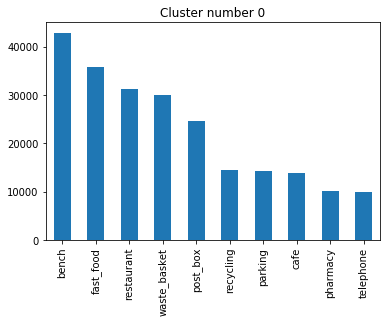

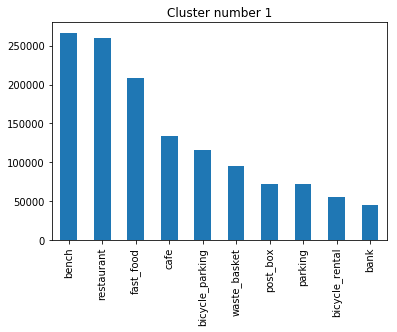

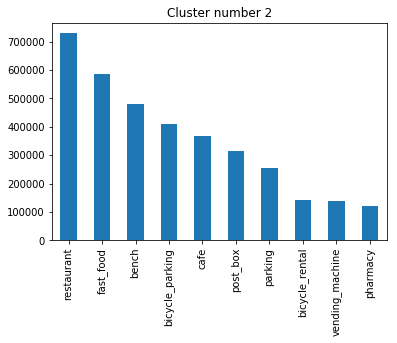

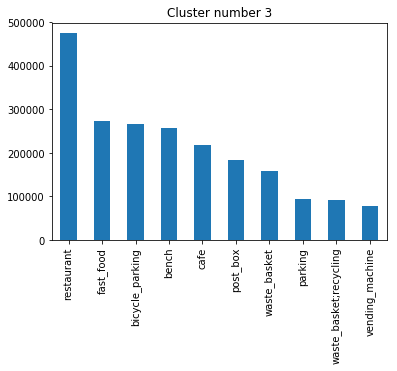

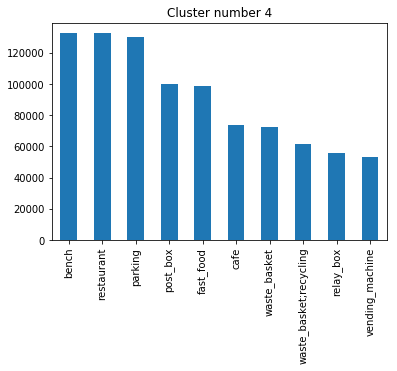

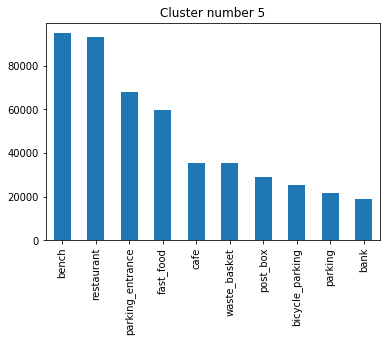

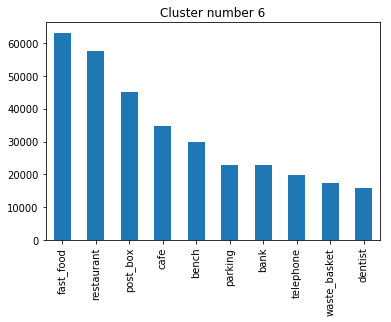

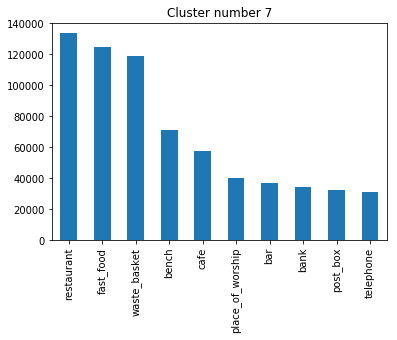

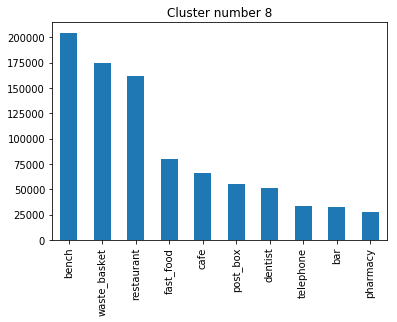

In [32]:
for i in range(0, toronto_cluster_analysis.shape[1]):
    cluster_topten = toronto_cluster_analysis.sort_values(by=[i], ascending=False).iloc[:10, i]
    
    cluster_topten.plot.bar(title="Cluster number {}".format(i))
    
    plt.show()

The plots above show us, that the number of fast food restaurants is a possible difference between the neighbourhoods in the center and the more remote neighbourhoods. It also shows that park benches is a not very specific feature.